In [1]:
# For interactive plots, comment the next line
%pylab inline
# For interactive plots, uncomment the next line
# %pylab ipympl
import warnings
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


# Introduction

This notebook demonstrates how to do a basic analysis using SMAP data.

Specifically, we will:

* Compare the previous year's soil moisture for a region of interest

<small>*For instructions on using Jupyter notebooks, see the [README.md](../../README.md) file.*</small>

## Setup

Make sure you have PODPAC installed with the **datatype** optional dependencies:

```
$ pip install podpac[datatype]
```

# How to analyze SMAP data using PODPAC

## Provide Earth Data Login Credentials
If you do not have an earth data login, or have not activated OpenDAP access, follow the [instructions here](https://creare-com.github.io/podpac-docs/user/earthdata.html).

In [2]:
import getpass
username = password = None
username = input("Username:");   password = getpass.getpass('Password:')

Username: mpuecker
Password: ··················


## Create the PODPAC Processing Pipeline

Look at the difference in soil moisture for the same date compared to the previous year:

1. Create the SMAP node to access SMAP data from NSIDC
2. Offset the user's requested coordinates
3. Specify an algorithm

In [3]:
import podpac
import podpac.datalib

# Create the SMAP node
product = 'SPL4SMAU'   # Level 4 soil moisture analysis update
smap = podpac.datalib.SMAP(product=product,
                           interpoloation='nearest', cache_type='disk',
                           username=username, password=password, )
smap

INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials


SMAP
	product: SPL4SMAU
	interpolation: None

In [4]:
# Offset the time from the requested time for the second node
# ExpandCoordinates can be used to specify a range.
# Here we're using it to offset the time of the incoming node by -1 year
smap_time1_offset = podpac.algorithm.ExpandCoordinates(source=smap,
                                                       time=['-1,Y', '-1,Y']  # [start_offset, end_offset]
                                                      )

# ExpandCoordinates is designed to work with a Reduction Node to work properly in a pipeline. 
# Use the "Mean" node to remove time from this Node so that xarray won't try to align the time dimensions
smap_offset = podpac.algorithm.Mean(source=smap_time1_offset, dims=['time'])

# Create the difference algorithm using an existing PODPAC Node
# this node calculates the difference between SMAP data (A) and SMAP data 1 year prior (B)
smap_diff = podpac.algorithm.Arithmetic(
              eqn='B-A',       # Specify point-wise operation between datasets (+, -, *, /, sin, cos, exp, ...) 
              A=smap,          # Specify the input for the "A" variable
              B=smap_offset,   # Specify the input for the "B" variable
)

# Create PODPAC Coordinates

This specifies the region and date where the pipeline will be evaluated

In [5]:
# Specify region of interest on a uniform grid
lat = podpac.crange(  60,  10, -2.0)  # (start, stop, step)
lon = podpac.crange(-130, -60,  2.0)  # (start, stop, step)

# Specify date and time
time = '2018-05-19T12:00:00'

# Create the PODPAC Coordinates
coords = podpac.Coordinates([lat, lon, time], dims=['lat', 'lon', 'time'])

# Evaluate the PODPAC pipeline and plot

* Retrieve subset of data needed from NSIDC
* Interpolate the data onto the requested grid
* Perform the user designed algorithm (Node "B" - Node "A")

INFO:pydap:Fetching URL: https://n5eil02u.ecs.nsidc.org/opendap/SMAP/SPL4SMAU.004/2018.05.19/SMAP_L4_SM_aup_20180519T120000_Vv4030_001.h5.dods?Analysis_Data_sm_surface_analysis[106:1:671][535:1:1285]
INFO:pydap:Fetching URL: https://n5eil02u.ecs.nsidc.org/opendap/SMAP/SPL4SMAU.004/2017.05.19/SMAP_L4_SM_aup_20170519T120000_Vv4030_001.h5.dods?Analysis_Data_sm_surface_analysis[106:1:671][535:1:1285]
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


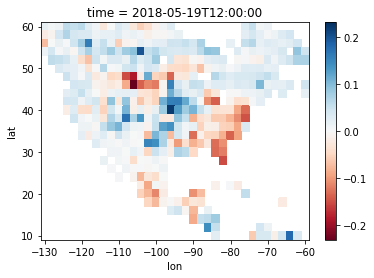

In [6]:
# Allow evaluation of arbitrary expressions, such as that used by the Arithmetic node
podpac.settings.set_unsafe_eval(True)

# Evaluate nodes
output = smap_diff.eval(coords)

# Plot the resulting differences
output.plot(cmap='RdBu')
pass

# Examine the PODPAC Pipeline

* PODPAC creates a text-based definition describing the pipeline automatically
* The pipeline definition can be used to share, recreate, and version control your analysis
* The pipeline definition can also be used to deploy a production web application with your analysis run in the cloud

In [7]:
print(smap_diff.json_pretty)

{
    "SMAP_SPL4SMAU": {
        "node": "datalib.smap.SMAP",
        "attrs": {
            "base_url": "https://n5eil02u.ecs.nsidc.org/opendap/SMAP",
            "product": "SPL4SMAU",
            "version": 4
        },
        "interpolation": null
    },
    "ExpandCoordinates": {
        "node": "core.algorithm.coord_select.ExpandCoordinates",
        "attrs": {
            "alt": [],
            "lat": [],
            "lon": [],
            "time": [
                "-1,Y",
                "-1,Y"
            ]
        },
        "inputs": {
            "coordinates_source": "SMAP_SPL4SMAU",
            "source": "SMAP_SPL4SMAU"
        }
    },
    "Mean": {
        "node": "core.algorithm.stats.Mean",
        "attrs": {
            "dims": [
                "time"
            ]
        },
        "inputs": {
            "source": "ExpandCoordinates"
        }
    },
    "Arithmetic": {
        "node": "core.algorithm.generic.Arithmetic",
        "attrs": {
            "eqn": "B